In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'pandas': '1.3.2'
}
check_packages(d)

[OK] Your Python version is 3.9.22 (main, May 30 2025, 05:30:51) [MSC v.1929 64 bit (AMD64)]
[OK] numpy 1.21.2
[OK] matplotlib 3.4.3
[OK] sklearn 1.0
[OK] pandas 1.3.2


In [3]:
from IPython.display import Image
%matplotlib inline

In [3]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [5]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


### Why Standard Scaling is Necessary in Machine Learning

Standard Scaling is a crucial data preprocessing step that rescales features to have a **mean of 0** and a **standard deviation of 1**. This is essential for algorithms that are sensitive to the magnitude of feature values.

**Key Reasons for Using Standard Scaling:**

* **Equal Feature Contribution:** It prevents features with larger scales (e.g., salary) from dominating and biasing algorithms over features with smaller scales (e.g., years of experience). This is critical for distance-based algorithms like **K-Nearest Neighbors (KNN)** and **Support Vector Machines (SVMs)**.
* **Faster Convergence for Optimization:** For algorithms that use Gradient Descent (e.g., **Linear Regression**, **Logistic Regression**, and **Neural Networks**), scaling the features helps the optimization process converge much faster and more reliably. Without it, the algorithm can take a slow, inefficient path to the optimal solution.
* **Improved Performance:** Many algorithms, including **Principal Component Analysis (PCA)**, assume that features are centered and have similar variances, making Standard Scaling a prerequisite for optimal performance.

### The Formula

Standard Scaling (or Z-score normalization) is calculated for each value in a feature using the formula:

$$z = \frac{x - \mu}{\sigma}$$

Where:
-   $z$ is the new scaled value.
-   $x$ is the original data point.
-   $\mu$ is the mean of the feature column.
-   $\sigma$ is the standard deviation of the feature column.

In [6]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [7]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [8]:
y_pred = ppn.predict(X_test_std)
print(f'Misclassified examples: {(y_test != y_pred).sum()}')

Misclassified examples: 1


In [9]:
from sklearn.metrics import accuracy_score

print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')

Accuracy: 0.978


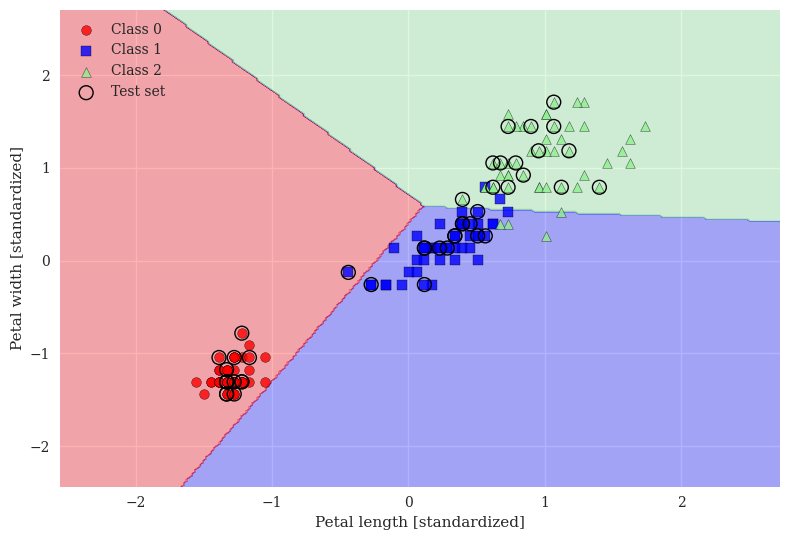

In [13]:
from utils.helper import plot_decision_regions
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined, ax=ax,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/03_01.png', dpi=300)
plt.show()

### The Big Picture: From a "Yes/No" Answer to a "How Likely?" Answer

Imagine you're building a machine learning model. Your last project was with something called a **Perceptron**. The Perceptron is like a very decisive friend—it only ever gives you a hard "yes" or "no" answer (in machine learning, we call this class 1 or class 0). But, as the text points out, the Perceptron has a big flaw: if the data isn't perfectly, cleanly separated into two groups, it gets confused and can never find the best answer. It's like trying to draw a single straight line to separate blue and red dots that are slightly mixed together; you'll always have some dots on the wrong side, and the Perceptron will keep trying to fix it forever.

This is where **Logistic Regression** comes in. Even though it has "regression" in the name, it's not for predicting a value like a stock price. It's a more sophisticated and powerful model for **classification** (choosing between categories).

Instead of a simple "yes" or "no," logistic regression gives you a **probability**—a number between 0 and 1 that tells you *how likely* it is that your data belongs to a certain class.

Think about it: which is more useful for a doctor?
* A model that says, "This patient has the disease." (A hard "yes")
* A model that says, "There is a 95% probability that this patient has the disease."

The second one gives you much more information! This probability is the core of logistic regression.

---

### The Challenge: How Do You Turn a Line into a Probability?

From your math classes, you know about linear equations like $y = mx + b$. In machine learning, we write it in a slightly different way, but it's the same idea:

$$z = w^Tx + b$$

Here, `x` represents the features (like a patient's symptoms), `w` represents the weights (how important each symptom is), and `b` is a bias. The result, `z`, is just a number. It can be a big positive number, a big negative number, or zero.

But probabilities have a very strict rule: they **must** be between 0 and 1.

So, the central question is: **How can we take our linear equation output `z` (which can be any real number) and transform it into a probability `p` (which must be between 0 and 1)?**

This is where the clever math comes in. We need a function that can "squish" the entire number line from $(-\infty, \infty)$ into the small range of $[0, 1]$. To find that function, we'll build it up using two concepts: **Odds** and the **Logit**.

#### Step 1: Probability and Odds

You're familiar with probability, `p`. For example, the probability that a patient has a disease is `p(y=1|x)`.

"Odds" are just another way of expressing that probability. The formula is:

$$\text{Odds} = \frac{p}{1-p}$$

* **p:** The probability that the event *happens*.
* **1-p:** The probability that the event *doesn't happen*.

**Example:** If the probability of winning a game is 75% (or 0.75), then `p = 0.75` and `1-p = 0.25`. The odds are:
$$\text{Odds} = \frac{0.75}{0.25} = 3$$
We would say the odds are "3 to 1" in favor of winning.

Now, let's look at the range of values that "Odds" can take:
* If `p` is close to 0 (very unlikely), the Odds are close to 0.
* If `p` is 0.5 (50/50 chance), the Odds are `0.5 / 0.5 = 1`.
* If `p` is close to 1 (very likely), `1-p` is tiny, so the Odds get huge and approach infinity.

So, the Odds transform our probability from a range of `[0, 1]` to a new range of `[0, \infty)`. We're getting closer, but we still need to include negative numbers.

#### Step 2: The Logit Function (Log-Odds)

You know from calculus that the natural logarithm function, `log(x)`, has a very useful property. Its domain is $(0, \infty)$ and its range is $(-\infty, \infty)$. It takes any positive number and maps it to the entire real number line!

This is exactly what we need. If we take the logarithm of the odds, we get the **logit function**:

$$\text{logit}(p) = \log\left(\frac{p}{1-p}\right)$$

Now, the output of our `logit(p)` function can be *any real number*, positive or negative.

#### The "Aha!" Moment: Connecting the Line and the Logit

We now have two things that can produce any value on the entire real number line:
1.  Our simple linear equation: $z = w^Tx + b$
2.  Our logit function: $\text{logit}(p)$

The huge assumption in logistic regression is to **set these two equal to each other**:

$$\log\left(\frac{p}{1-p}\right) = w^Tx + b = z$$

This is the central equation. It says that the **log-odds** of an event happening are related to its features in a simple, linear way.

### The Final Step: Getting the Probability Back with the Sigmoid Function

This is great, but we set out to find the probability `p`, not the log-odds. So, we need to solve the equation above for `p`. This is where your algebra and calculus knowledge comes in handy.

Starting with:
$$\log\left(\frac{p}{1-p}\right) = z$$

To get rid of the log, we take the exponential (`e`) of both sides:
$$\frac{p}{1-p} = e^z$$

Now, we just solve for `p`:

$$p = e^z(1-p)$$

$$p = e^z - p \cdot e^z$$

$$p + p \cdot e^z = e^z$$

$$p(1 + e^z) = e^z$$

$$p = \frac{e^z}{1 + e^z}$$

This formula works, but there is a more common and stable way to write it. If you divide both the numerator and denominator by $e^z$, you get:

$$p = \frac{1}{\frac{1}{e^z} + 1} = \frac{1}{1 + e^{-z}}$$

This final, beautiful function is called the **Logistic Sigmoid Function**. Let's call it $\phi(z)$:

$$\phi(z) = \frac{1}{1 + e^{-z}}$$

This function is the magic key. It takes any real number `z` from our linear equation and squishes it perfectly into a value between 0 and 1. If you graph it, you'll see it makes a characteristic "S" shape.

* If `z` is a large positive number, $e^{-z}$ is close to 0, so $\phi(z) \approx 1$.
* If `z` is a large negative number, $e^{-z}$ is huge, so $\phi(z) \approx 0$.
* If `z` is 0, $\phi(z) = 1/(1+1) = 0.5$.

### Summary of the Workflow

So, to predict the probability that a new patient has a disease, the logistic regression model does this:

1.  **Calculate the Score:** It takes the patient's features `x` (symptoms), multiplies them by the learned weights `w`, adds the bias `b`, and gets a score `z`.
    $$z = w^Tx + b$$
2.  **Calculate the Probability:** It feeds this score `z` into the sigmoid function to get the final probability `p`.
    $$p = \phi(z) = \frac{1}{1 + e^{-z}}$$

If `p` > 0.5, the model classifies it as class 1 ("has disease"). If `p` < 0.5, it's class 0 ("does not have disease"). But the real power is that we get to keep the actual probability `p` itself.

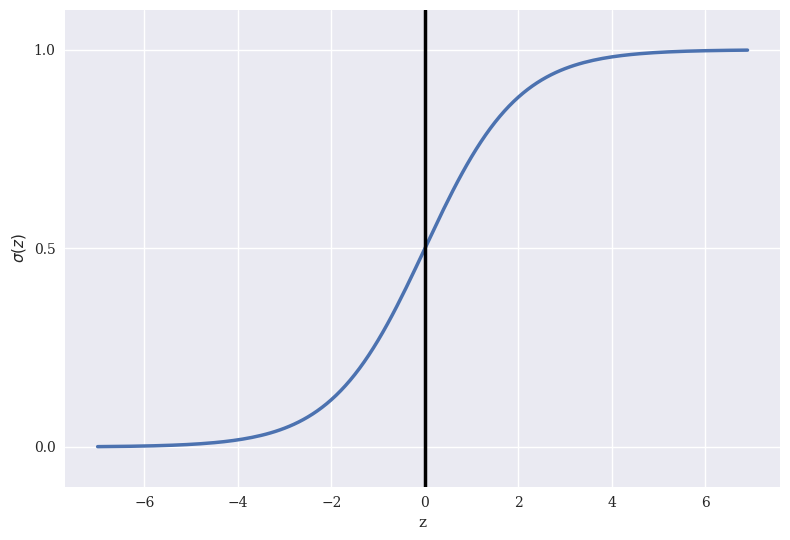

In [15]:
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)

plt.plot(z, sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('figures/03_02.png', dpi=300)
plt.show()

### The Goal: How Do We "Teach" the Model?

Imagine you've built your logistic regression model. Right now, its internal "weights" (`w`) and "bias" (`b`) are just random numbers. It's like a student who hasn't studied for a test—its answers will be completely random guesses.

To teach the model, we need a way to grade its performance. We'll show it our training data (the questions and the correct answers) and score how well it does. Based on that score, we'll tell the model how to adjust its weights to do better on the next try. We repeat this process until its score is as good as it can get.

In the past, you saw a simple way to score a model called the **Mean Squared Error**. It basically measured the distance between the model's guess and the right answer. For this new model, we're going to use a more powerful and elegant method.

### A New Idea: Instead of Minimizing "Wrongness," Let's Maximize "Rightness"

Instead of calculating a "penalty" or "error" score, let's try to calculate a "correctness" score. We'll call this score the **Likelihood**.

The likelihood answers this question:

> "Given our model's current settings (its weights `w` and `b`), what is the total probability of it producing the exact set of correct answers we see in our data?"

A good model will look at our data and say, "Yes, based on my settings, this data is very likely to have happened!" A bad model will say, "Whoa, according to my settings, the data you have is extremely unlikely."

Our goal, therefore, is to **tweak the weights `w` and `b` to make the Likelihood as high as possible.** We want to find the settings that make our actual data seem the most probable.

### The Math of Likelihood: A Clever Trick

So how do we calculate this total probability?

First, we assume each data point (e.g., each patient in a medical study) is **independent**. This is like flipping a coin multiple times; the result of one flip doesn't affect the next. The probability of getting Heads, then Tails is `P(H) * P(T)`.

To find the total likelihood for our whole dataset, we just **multiply** the individual probabilities for each data point. The big Pi symbol, `Π`, in the formula just means "multiply everything together," like how `Σ` means "add everything together."

Now for the clever trick. How do we write the probability for a *single* data point? Let's say:
* `φ(z)` is our model's predicted probability that the answer is "Yes" (Class 1).
* `y` is the *actual* correct answer (either 1 for "Yes" or 0 for "No").

We can write one magic formula that works for both cases:

$$P(y|\mathbf{x}) = \phi(z)^y (1 - \phi(z))^{1-y}$$

Let's test this. You know from math that anything to the power of 0 is 1, and anything to the power of 1 is itself.

* **Case 1: The correct answer is `y=1` ("Yes")**
    The formula becomes: $\phi(z)^1 (1 - \phi(z))^{1-1} = \phi(z) \cdot (1 - \phi(z))^0 = \phi(z) \cdot 1 = \phi(z)$.
    This is exactly what we want! If the answer is "Yes," the score is just the model's predicted probability of "Yes." To make this score high, the model needs to make `φ(z)` high.

* **Case 2: The correct answer is `y=0` ("No")**
    The formula becomes: $\phi(z)^0 (1 - \phi(z))^{1-0} = 1 \cdot (1 - \phi(z))^1 = 1 - \phi(z)$.
    This is also what we want! The probability of "No" is `1 - φ(z)`. To make this score high, the model needs to make `1 - φ(z)` high, which means making `φ(z)` low (close to 0).

This single, clever formula correctly measures the "rightness" for any data point!

### Making the Math Easier: Using Logs

Multiplying lots of small probabilities (e.g., 0.9 * 0.7 * 0.95 * ...) is a nightmare for computers. The numbers can become so tiny that the computer just rounds them to zero, which breaks everything.

Here's where your calculus knowledge comes in. You know a log rule: `log(a * b) = log(a) + log(b)`. Logarithms turn multiplication into addition!

So, instead of maximizing the Likelihood, we can maximize the **Log-Likelihood**. It's the same goal (if `log(x)` is at its max, then `x` is too), but it's much easier to work with. Our big multiplication `Π` problem becomes a big addition `Σ` problem, which is much nicer for computers and for doing calculus.

### Flipping the Problem: From Maximizing a Score to Minimizing a Loss

Most optimization algorithms, like the Gradient Descent you've seen, are designed to find the *minimum* of a function (the bottom of a valley). But we want to find the *maximum* of our Log-Likelihood function.

The solution is simple: **maximizing a function `f(x)` is the same as minimizing its negative, `-f(x)`**. Think about it: the highest point on a mountain is the lowest point in a valley of the same shape, but flipped upside down.

So, we flip our Log-Likelihood function by putting a minus sign in front of it. We call this new function that we want to minimize the **Loss Function**.

$$Loss = - \text{log-likelihood}$$

### Putting It All Together: The Final Loss Function

For a single data point, the loss looks like this:

$$L = -[y \cdot \log(\phi(z)) + (1-y) \cdot \log(1 - \phi(z))]$$

Let's look at it one last time:
* If the true answer is **`y=1`**, the loss is $L = - \log(\phi(z))$. To make the loss small (close to 0), the model needs to make `φ(z)` close to 1, because `log(1) = 0`.
* If the true answer is **`y=0`**, the loss is $L = - \log(1 - \phi(z))$. To make the loss small, the model needs to make `1 - φ(z)` close to 1 (meaning `φ(z)` is close to 0). Again, this gives a loss near 0.

If the model is very confident but **wrong** (e.g., `y=1` but `φ(z)` is 0.001), the loss becomes `-log(0.001)`, which is a huge positive number. This high loss value tells the model, "You made a very bad mistake here; you need a big correction!"

So, by using gradient descent to minimize this loss function, we are teaching our model to adjust its weights `w` and `b` until it produces the highest possible probabilities for all the correct answers in our training data.

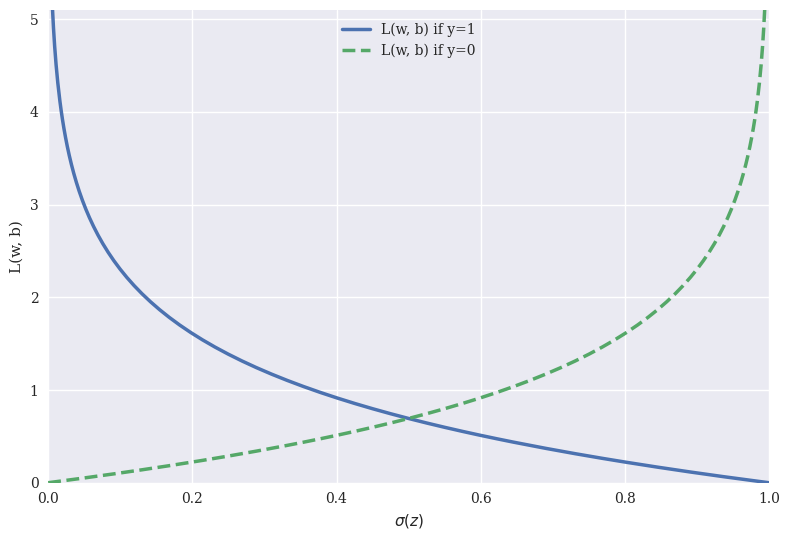

In [16]:
def loss_1(z):
    return - np.log(sigmoid(z))


def loss_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)

c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label='L(w, b) if y=1')

c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

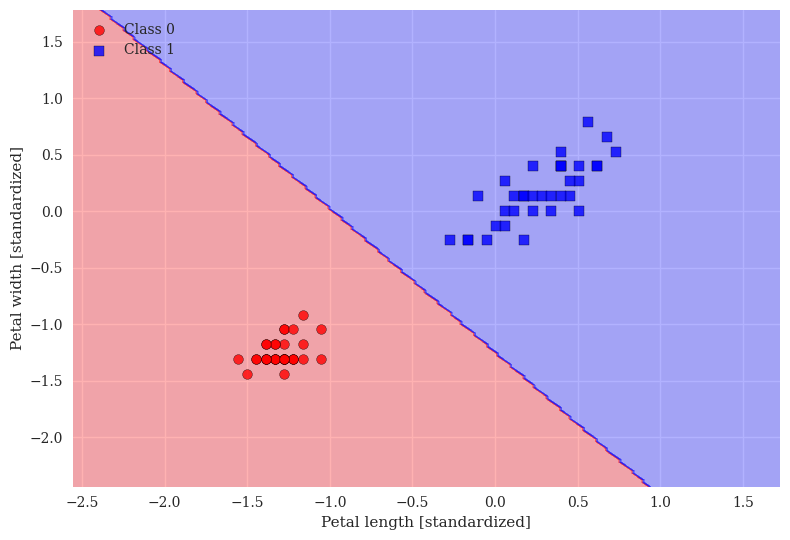

In [18]:
from utils.helper import LogisticRegressionGD

X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

fig, ax = plt.subplots()

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      ax=ax,
                      classifier=lrgd)

plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()

plt.show()

lets try the logistic regression model in scikit-learn

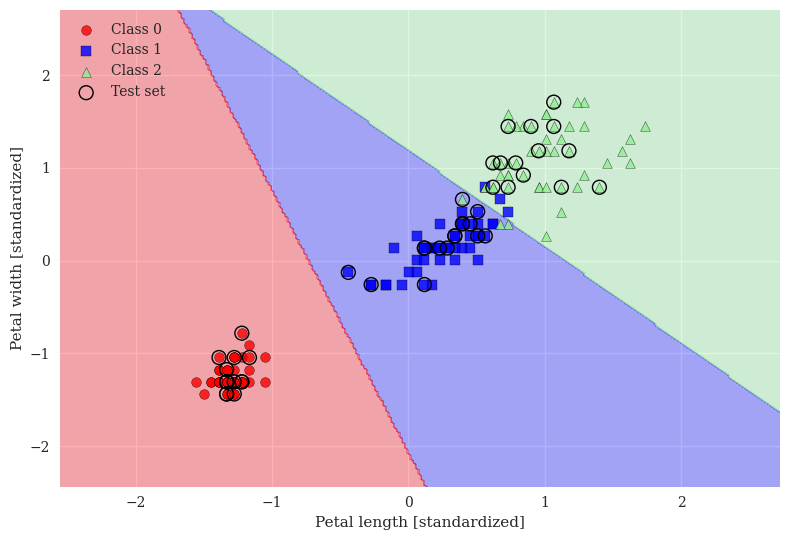

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)

fig, ax = plt.subplots()

plot_decision_regions(X_combined_std, y_combined, ax=ax,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

In [21]:
lr.predict_proba(X_test_std[:3, :])

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

In [22]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [23]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0], dtype=int64)

In [24]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [25]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

### 🧠 What’s the Problem?

When we train a machine learning model (like teaching a computer to recognize flowers), it can make two types of mistakes:

* **Overfitting**: The model remembers the training data *too well*, like a student who memorizes answers but can't handle new questions. It does great on practice tests but bad on real ones.
* **Underfitting**: The model is *too simple* to understand the patterns, like a student who doesn’t study enough and just guesses.

---

### 🎯 Bias vs. Variance

* **Bias** = model is too simple and makes lots of mistakes (underfitting).
* **Variance** = model is too complex and changes too much with different data (overfitting).
* A good model needs a **balance** between bias and variance.

---

### 🔧 How Do We Fix Overfitting?

We use a trick called **regularization**.

* Regularization keeps the model from going “crazy” by **penalizing extreme values** in its settings (called weights).
* It's like putting limits on how wild the model can get.
* **L2 regularization** is one common type — it encourages smaller weights, which usually helps generalize better to new data.

---

### ⚙️ What’s That `C` Parameter?

* In scikit-learn (a Python library), we adjust regularization using the `C` parameter:

  * **Smaller `C`** → stronger regularization → simpler model (less overfitting).
  * **Larger `C`** → weaker regularization → more complex model.

You can think of `C` as a dial: turn it one way to make the model stricter (avoid overfitting), turn it the other to let it be more flexible.

---

### 📏 Why Feature Scaling Matters

* To make regularization work properly, all features (inputs) must be on similar scales (like cm vs. kg).
* That’s why we **standardize** features before training.

---

### 📉 Visual Tools

We can **plot** how changing `C` affects the model — this helps us see how regularization changes the model’s “weight settings.”



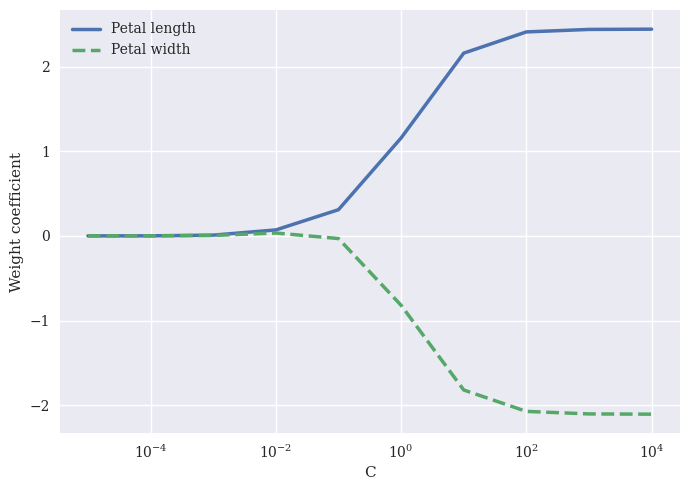

In [26]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c,
                            multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='Petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='Petal width')
plt.ylabel('Weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')

plt.show()

## **Support Vector Machine (SVM)**

### 🌟 What's the Main Idea?

When training a computer to tell things apart—like different kinds of flowers—we want it to **draw a line (or boundary)** between the classes. A **Support Vector Machine (SVM)** is a special tool that finds the **best possible line**, by making the **gap (margin)** between the classes as wide as possible.

Why? Because a **wider margin** usually means the model will do better on new, unseen data.

---

### 🧱 What’s the Big Deal About the Margin?

* **Big margin = better generalization** (the model works well on future data).
* **Small margin = model might memorize too much** and overfit.

---

### 🧠 But Why Not Always a Big Margin?

Sometimes, the data is **messy** or **overlaps** (not perfectly separated), so we can't draw a line that divides them without making a few mistakes.

That’s where **slack variables** come in:
They let the model **bend the rules a little**, allowing for some mistakes to still get a good, wide margin.

---

### 🎛 What Is `C` in SVM?

* `C` is a **penalty knob** that controls how much we care about mistakes:

  * **Big `C`**: Model tries really hard to avoid mistakes (may overfit).
  * **Small `C`**: Model allows some mistakes to keep the margin wide (may underfit).

So, `C` helps find a balance between **being too strict** and **being too relaxed**—this is called the **bias-variance tradeoff**.

---

### 📘 Want to Go Deeper?

The math behind all this is pretty tough (college level!), but if you're curious, there are great resources like:

* Andrew Ng’s lecture notes
* Books by Vapnik (the inventor of SVM)
* Chris Burges’ tutorial on SVMs



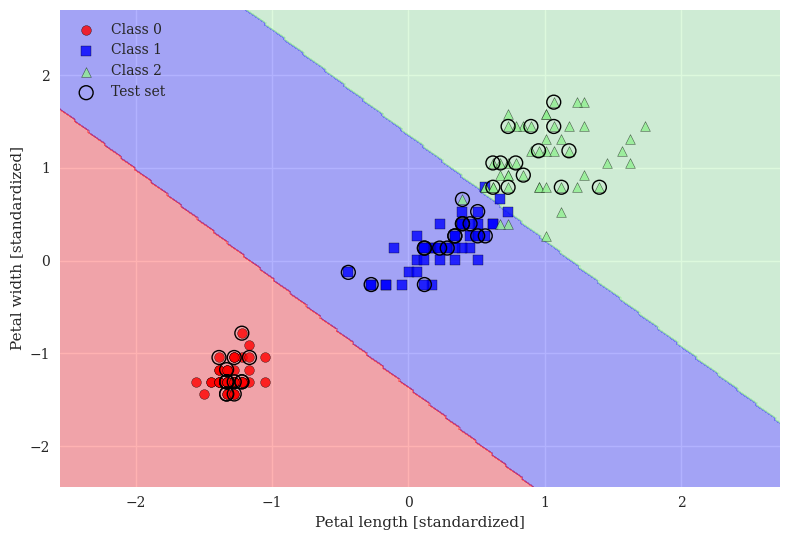

In [28]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

fig, ax = plt.subplots()

plot_decision_regions(X_combined_std, 
                      y_combined, ax=ax,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

### Alternative implementations in scikit-learn

In [29]:
from sklearn.linear_model import SGDClassifier

ppn = SGDClassifier(loss='perceptron')
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')

## Solving non-linear problems using a kernel SVM

**SVM vs Logistic Regression: Key Differences**

### **1. Decision Boundary Approach**

**Logistic Regression:**
- Finds a boundary that minimizes classification errors across ALL data points
- Cares about every single training example when drawing the line
- Uses probability-based approach (sigmoid function)

**SVM:**
- Only cares about the data points closest to the boundary (support vectors)
- Ignores points that are "obviously" on the correct side
- Focuses on maximizing the "margin" (widest possible gap between classes)

### **2. Handling Linearly Inseparable Data**

**Logistic Regression:**
- Struggles with complex, non-linear patterns like XOR
- The sigmoid function is inherently linear in its decision boundary
- Would perform poorly on the XOR dataset mentioned

**SVM:**
- Excels at non-linear problems using the "kernel trick"
- Can transform data into higher dimensions where linear separation becomes possible
- Perfect for XOR-type problems that can't be separated by straight lines

### **3. Output Interpretation**

**Logistic Regression:**
- Gives you probabilities: "I'm 73% confident this is class 1"
- Useful when you need uncertainty estimates

**SVM:**
- Gives you definitive classifications: "This is class 1, period"
- Less informative about confidence levels

### **4. Training Philosophy**

**Logistic Regression:**
- Democratic: Every data point gets a vote in where the boundary goes
- Minimizes overall loss across the entire dataset

**SVM:**
- Elitist: Only the "difficult" boundary cases (support vectors) matter
- Maximizes the safety margin, ignoring easy-to-classify points

### **For the XOR Problem You Mentioned:**
- **Logistic Regression**: Would struggle, likely achieving ~50% accuracy
- **Kernel SVM**: Would easily achieve near-perfect separation by mapping to higher dimensions

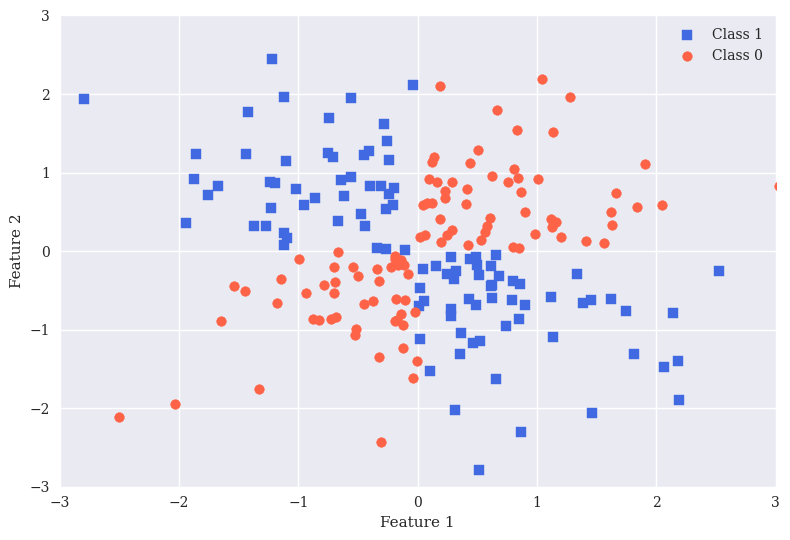

In [30]:

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='royalblue',
            marker='s',
            label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0],
            X_xor[y_xor == 0, 1],
            c='tomato',
            marker='o',
            label='Class 0')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('figures/03_12.png', dpi=300)
plt.show()

## Using the kernel trick to find separating hyperplanes in higher dimensional space

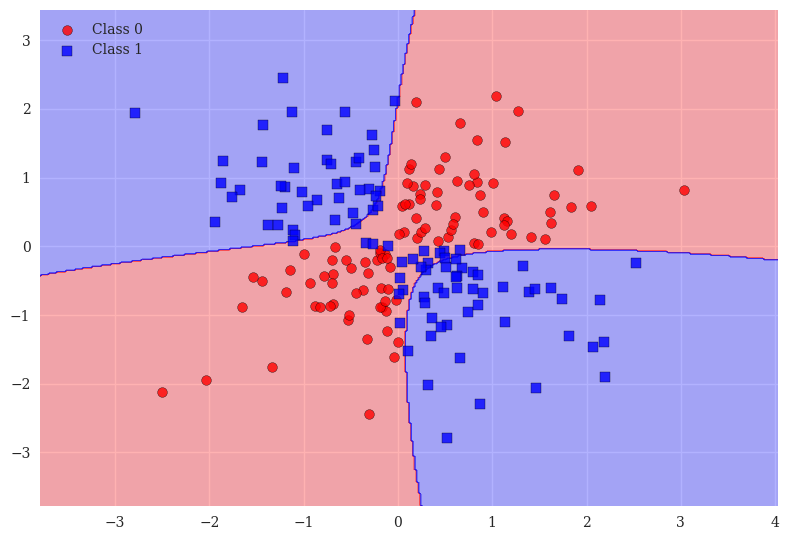

In [35]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)

fig, ax = plt.subplots()

plot_decision_regions(X_xor, y_xor, ax=ax,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

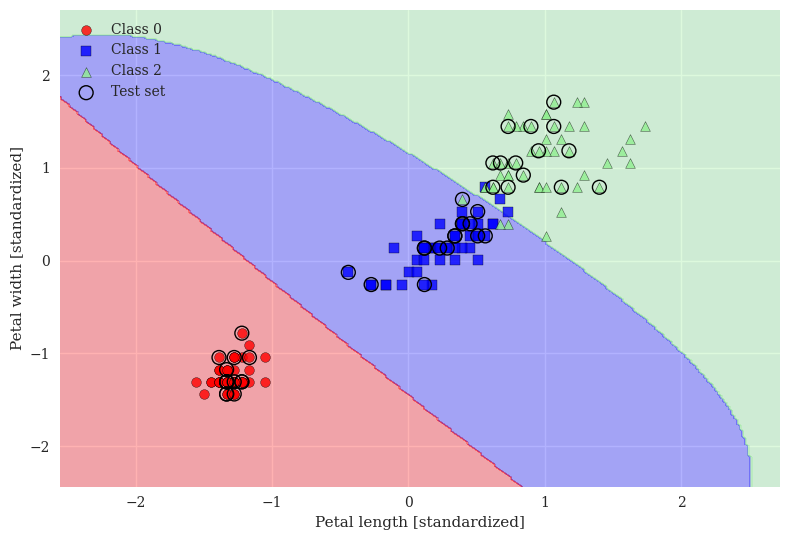

In [36]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

fig, ax = plt.subplots()

plot_decision_regions(X_combined_std, y_combined, ax=ax,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

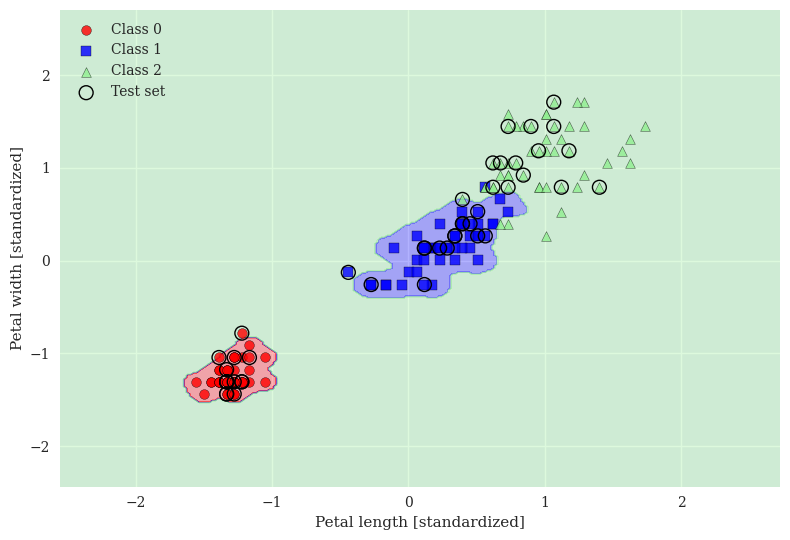

In [37]:
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

fig, ax = plt.subplots()

plot_decision_regions(X_combined_std, y_combined, ax=ax,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

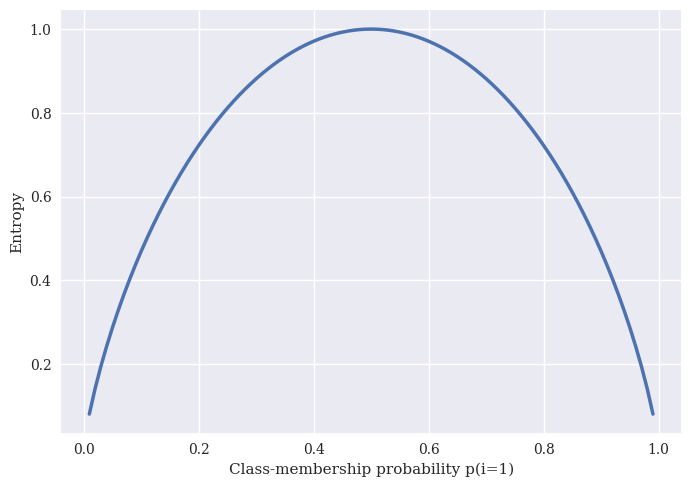

In [38]:
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None 
       for p in x]

plt.ylabel('Entropy')
plt.xlabel('Class-membership probability p(i=1)')
plt.plot(x, ent)

plt.show()

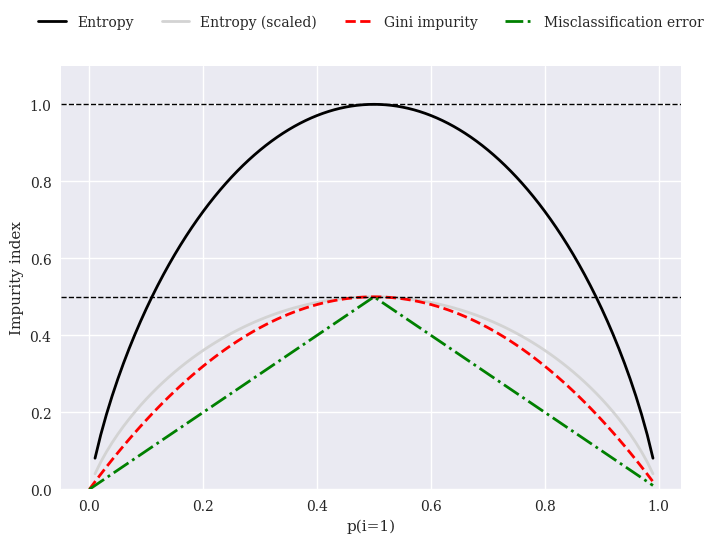

In [39]:
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini impurity', 'Misclassification error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity index')

plt.show()

# **Building a decision tree**

## The Gini Coefficient: From Economics to Decision Trees

### What is the Gini Coefficient? (Explained for a Third Grader)

Imagine you and your friends are sharing candy after Halloween. The Gini coefficient is like a special number that tells us how fairly the candy is shared among everyone.

If everyone gets exactly the same amount of candy, the Gini number is 0 - that means "perfectly fair sharing!"

If one person gets ALL the candy and everyone else gets nothing, the Gini number is 1 - that means "totally unfair!"

Most of the time, the number is somewhere between 0 and 1. The closer to 0, the more fair the sharing is. The closer to 1, the more unfair it is.

### Who Created It and When?

The Gini coefficient was invented by an Italian man named **Corrado Gini** in 1912. He was a statistician (someone who studies numbers and patterns) who wanted a simple way to measure inequality - basically, how unfairly things are shared among people.

Back then, Corrado Gini was studying how wealth (money and valuable things) was distributed among people in different countries. He noticed that some countries had a few very rich people and many poor people, while other countries had people with more similar amounts of money.

#### **How Did Corrado Gini Collect Data in 1912?**

In 1912, collecting data was much harder than today! Corrado Gini had to be very creative:

**Government Records**: He looked at tax records, property ownership documents, and census data that governments kept by hand in big books.

**Manual Surveys**: People would go door-to-door with pencil and paper, asking families about their income and possessions. Imagine having to walk to every house in a city!

**Industrial Reports**: He studied reports from factories and businesses about how much they paid their workers.

**Agricultural Data**: Since most people were farmers back then, he looked at land ownership records and crop production data.

**No Computers**: Everything was calculated by hand using basic math and simple calculating machines. What takes us seconds today took weeks or months back then!

### How It's Used Today

Today, the Gini coefficient is used all around the world to measure inequality in many different ways:

#### How Do Governments Collect This Data Today?

Modern governments have much more sophisticated ways to gather data:

**Digital Tax Systems**: Governments automatically collect income data from employers, banks, and businesses through electronic filing systems.

**Large-Scale Surveys**: Organizations like the U.S. Census Bureau conduct detailed household surveys using statistical sampling - they don't need to ask everyone, just a representative sample.

**Administrative Records**: Governments link data from multiple sources - tax records, social security, unemployment benefits, property records - all stored in computer databases.

**Electronic Banking Data**: With permission and privacy protections, some countries can analyze spending patterns and income flows through digital banking systems.

**International Cooperation**: Organizations like the World Bank and OECD help countries standardize how they collect and compare inequality data.

**Real-Time Processing**: Computers can process millions of records instantly and calculate Gini coefficients for entire countries in minutes instead of months!

#### In Economics and Government
- **Countries** use it to measure how fairly wealth is shared among their citizens
- **Policy makers** use it to decide if they need laws to help reduce inequality
- **Economists** compare different countries to see which ones have fairer wealth distribution

#### Examples of Gini Coefficients by Country (2024)
- **Denmark**: 0.28 (very fair wealth sharing)
- **United States**: 0.41 (moderate inequality)
- **South Africa**: 0.63 (high inequality)

#### Other Uses
- Measuring income differences between men and women
- Looking at educational opportunities across different groups
- Studying health care access in different regions

### How It Works in Decision Trees

Now here's where it gets really interesting for computer science! The Gini coefficient isn't just used for measuring wealth inequality - it's also used in something called **decision trees**.

#### What are Decision Trees?
Think of a decision tree like a flowchart that helps a computer make decisions. It asks yes/no questions to figure out the right answer, just like playing "20 Questions."

For example, if we want to teach a computer to decide if someone should play outside:
- Is it raining? (Yes/No)
- Is it too cold? (Yes/No)
- Is it a school day? (Yes/No)

#### Gini Impurity in Decision Trees

In decision trees, we use something called **"Gini Impurity"** - it's the same math as the Gini coefficient, but we're measuring something different.

Instead of measuring how unfairly candy or money is shared, we're measuring how "mixed up" our data is.

#### Here's How It Works:

**Step 1: Start with Mixed-Up Data**
Let's say we have a box of fruits, and we want the computer to learn how to sort them:
- 5 apples
- 5 oranges
- Total: 10 fruits

This box is very "mixed up" because it has equal amounts of both fruits. The Gini Impurity would be high (close to 0.5).

**Step 2: Make Better Groups**
Now let's say we sort them by color:
- Red box: 5 apples, 0 oranges (perfectly sorted!)
- Orange box: 0 apples, 5 oranges (perfectly sorted!)

Each box now has only one type of fruit. The Gini Impurity for each box is 0 (perfectly sorted).

**Step 3: The Computer Learns**
The decision tree algorithm looks for ways to split the data that reduce the Gini Impurity the most. It wants to create groups that are as "pure" (un-mixed) as possible.

#### The Math (Simplified)

For our fruit example:
- **Before splitting**: Gini = 0.5 (very mixed up)
- **After splitting by color**: Gini = 0 (perfectly sorted)

The computer says: "Great! Splitting by color worked really well!"

#### Real-World Example

Imagine we're teaching a computer to decide if someone will like a movie:

**Starting data**: 100 people
- 60 liked the movie
- 40 didn't like it
- Gini Impurity = 0.48 (pretty mixed up)

**Split by age**:
- Under 25: 45 people (40 liked it, 5 didn't) - Gini = 0.22
- Over 25: 55 people (20 liked it, 35 didn't) - Gini = 0.45

The computer sees that splitting by age made much "purer" groups, especially for younger people!

#### Why This Matters

Using Gini Impurity helps decision trees:
1. **Make better decisions** by finding the best questions to ask
2. **Work faster** by focusing on the most important features
3. **Be more accurate** by creating cleaner groups

### From Measuring Fairness to Making Decisions

It's amazing how the same mathematical idea that Corrado Gini created in 1912 to measure economic fairness is now used to help computers make smart decisions! 

Whether we're talking about sharing candy fairly among friends or helping a computer sort data into neat groups, the Gini coefficient helps us understand and measure how "mixed up" or "pure" things are.

The next time you see a recommendation on Netflix or get a suggestion on what to buy online, there's a good chance that a decision tree using Gini Impurity helped make that recommendation!

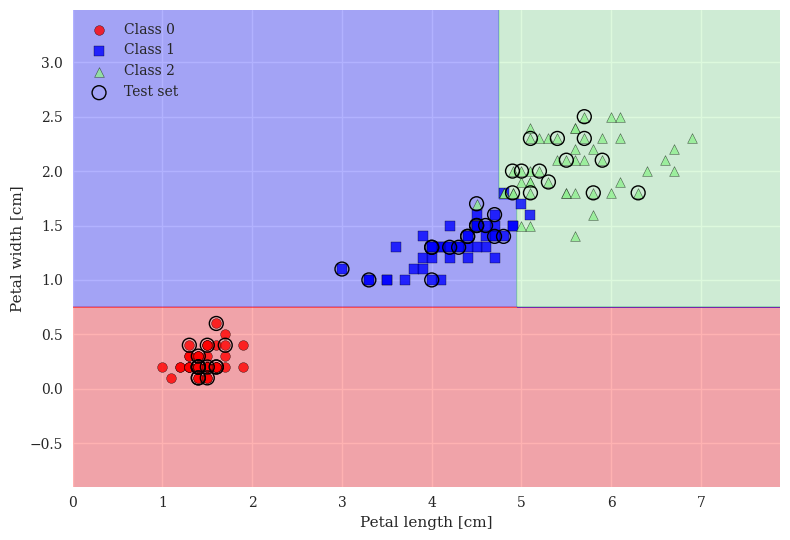

In [40]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

fig, ax = plt.subplots()

plot_decision_regions(X_combined, y_combined, ax=ax,
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

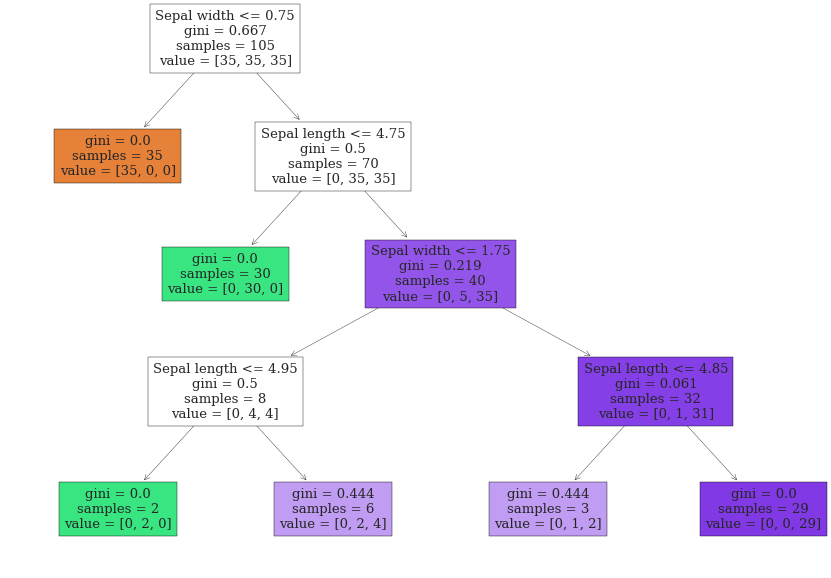

In [41]:
from sklearn import tree

feature_names = ['Sepal length', 'Sepal width',
                 'Petal length', 'Petal width']
tree.plot_tree(tree_model,
               feature_names=feature_names,
               filled=True)


plt.show()


### 🌳 What is this Tree Doing?

It’s trying to **classify iris flowers** into 3 species, based on their **sepal length and width** (and maybe other features too, like petal length, but here we see only sepals used).

The three numbers inside each box:

```
value = [Setosa, Versicolor, Virginica]
```

For example:
`value = [35, 0, 0]` means **35 Setosa**, **0 Versicolor**, **0 Virginica**.

---

### 🔍 Root Node — Starting Point

```plaintext
Sepal width <= 0.75
samples = 105
gini = 0.667
value = [35, 35, 35]
```

👆 This is the **top of the tree**, the starting point.
It means:

* We're looking at 105 total flower samples.
* There are **35 of each species**, evenly distributed.
* The **gini = 0.667** tells us this group is **very mixed up** (higher = more mixed).

**Question it asks**:
“Is the sepal width less than or equal to 0.75?”

If **YES**, go **left**
If **NO**, go **right**

---

### 🌿 Left Branch: Very Thin Sepals

```plaintext
value = [35, 0, 0]
gini = 0.0
```

🟧 It finds that **35 flowers** have super-thin sepals and **they're all Setosa!**
Gini is 0 = **perfectly pure group**.

**This is a leaf node**: No further splitting needed.

---

### 🌿 Right Branch: Thicker Sepals

```plaintext
Sepal length <= 4.75
samples = 70
value = [0, 35, 35]
gini = 0.5
```

Now we look at the remaining 70 flowers. The question is:

**“Is the sepal length <= 4.75?”**

* If YES → go left
* If NO → go right

Now we’re separating **Versicolor and Virginica**.

---

### 🟢 Left of Right: Short Sepals

```plaintext
value = [0, 30, 0]
gini = 0.0
```

🥬 These 30 flowers have short sepals and are **all Versicolor**.
Perfect classification again.

---

### 🌿 Right of Right: Long Sepals

```plaintext
Sepal width <= 1.75
value = [0, 5, 35]
gini = 0.219
```

Now we’re deciding among **5 Versicolor and 35 Virginica**.
Still some mixing, but mostly Virginica.

**Question**: Is the sepal width small?

If YES, go left (more Versicolor)
If NO, go right (mostly Virginica)

---

### 🟣 Bottom Left

```plaintext
Sepal length <= 4.95
value = [0, 4, 4]
gini = 0.5
```

🤔 Equal mix of 4 Versicolor, 4 Virginica → very mixed.

Then it splits again:

* Very short sepals → \[0, 2, 0]
* A bit longer sepals → \[0, 2, 4] (some mix)

---

### 🟪 Bottom Right

```plaintext
Sepal length <= 4.85
value = [0, 1, 31]
gini = 0.061
```

😎 Very low Gini → almost all Virginica.
Split again and finally get to:

```plaintext
value = [0, 0, 29]
gini = 0.0
```

✅ Perfectly classified Virginicas!

---

### 🔚 Summary (Like a Storybook Ending)

* The **tree starts with 105 flowers** and keeps asking smart questions.
* At each level, it tries to **split the data into purer groups**.
* Eventually, it finds **"pure leaf nodes"** where all flowers belong to one class.
* That’s how a decision tree "learns" to recognize patterns!


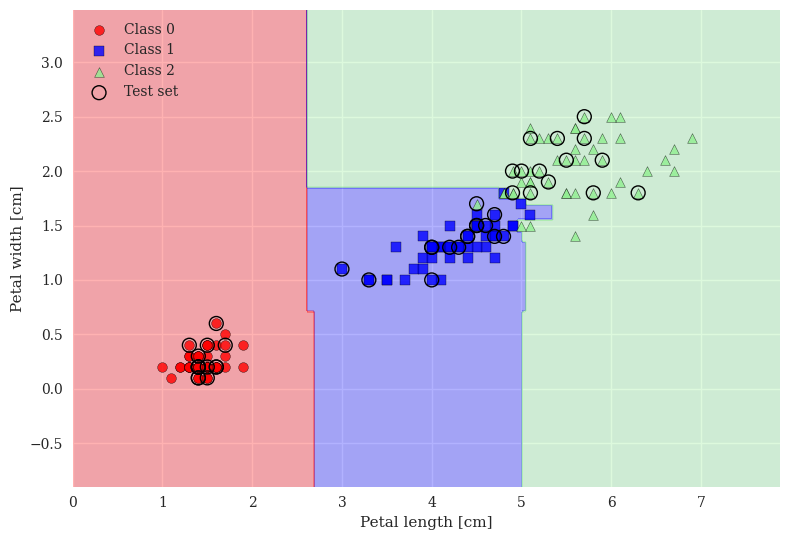

In [42]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

fig, ax = plt.subplots()

plot_decision_regions(X_combined, y_combined, ax=ax,
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

## K-nearest neighbors - a lazy learning algorithm

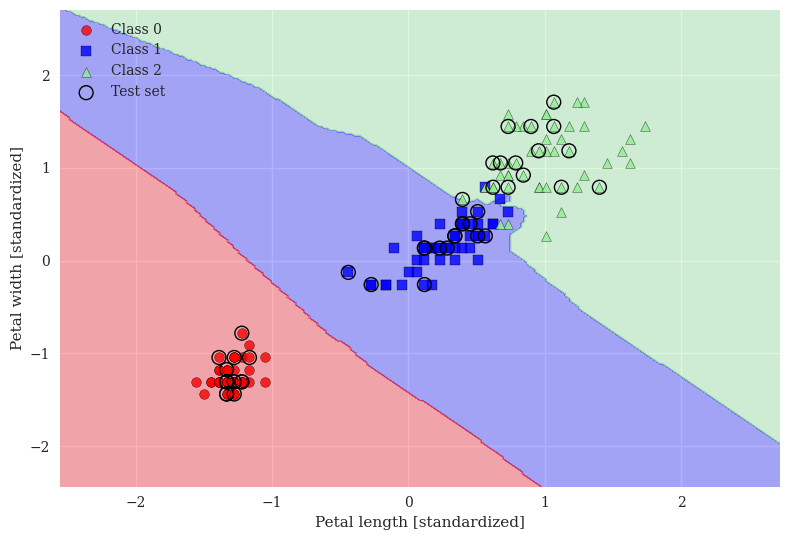

In [43]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

fig, ax = plt.subplots()

plot_decision_regions(X_combined_std, y_combined, ax=ax,
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()